# Algorithms comparison - Supervised
In this notebook I am going to use the pre-processed data to train various algorithms. I will compare its performance using some numerical metrics and plots. 

## Getting the data

In [1]:
# Importing main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be run one time

In [2]:
build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='RD_dataset')

A file with that name already exists


In [3]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


I'm going to separate the table in two: one with the standarized variables and the other with the labels. Then, into a training set and a test set

In [4]:
df_RD = df.sample(100000, random_state = 1)
X, y = separate_data(df_RD)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training y 30% test

## Metrics
As I am going to test different classifiers, I need numerical values that allow us to evaluate the performance of the algorithms. Some useful values are: 

### Confusion matrix

A confusion matrix is a tool that allows you to visualize the performance of a supervised learning algorithm. The diagonal elements represent the number of points for which the predicted label equals the true label, while the off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix, the better, indicating many correct predictions. 
![](https://i.imgur.com/wi89FjN.png)

Where:
- **TP**: True positive
- **FP**: False positive
- **FN**: False negative
- **TN**: True negative

### Accuracy
It is the number of correct predictions made by the model over all the type of predictions made: 
$$ 
\text{Accuracy} = \frac{TP+TN}{TP+FP+FN+TN}
$$

This is a good measure when the classes in the data are well balanced. It should not be used as a measure when the target variable classes in the data are the majority of a class. 

### Precision
Indicates the proportion of true positives, in our case, what proportion of the signal labeled by the model as a signal is truly a signal: 
$$
\text{Precision} = \frac{TP}{TP+FP}
$$

The precision gives us information about the performance of the classifier with respect to false positives, how many it caught. 

### Sensibility or recall
In our case, it indicates the signal ratio was successfully tagged as signal: 
$$
\text{Sensibility} = \frac{TP}{TP+FN}
$$
Where:
- The actual signal is TP and FN
- The signal fraction predicted by the model is TP

The sensitivity gives us information about the performance of the classifier with respect to false negatives, how many it failed. 

### Specificity
It is the measure that tells us the proportion of the background that was predicted by the model as the background. The negatives (the data that are actually background are FP and TN) and the background according to the model (TN): 
$$ 
\text{Specificity} = \frac{TN}{TN+FP}
$$

Specificity is the opposite of sensitivity. 

### F1 Score
It is the harmonic mean between precision and sensitivity. It can be interpreted as a weighted average of precision and sensitivity, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 
$$
F1 = 2\frac{\text{precision}\times\text{sensibility}}{\text{precicion}+\text{sensibility}}
$$

### Log loss
It works by penalizing the wrong classification. Suppose N samples in M classes: 
$$
LL = \frac{-1}{N}\sum^N_{i=1}\sum^M_{j=1}y_{ij}*\text{log}(p_ij)
$$
Donde:
- $y_{ij}$ indicates if the sample belongs to class *i* or *j* or not 
- $p_{ij}$ indicates the probability that the sample of class *i* belongs to class *j*.

The logarithmic loss has no upper limit. A logarithmic loss near 0 indicates greater accuracy. In general, minimizing the logarithmic loss increases the accuracy of the classifier. 

## Classifiers
We are going to iterate over a list of classifiers, to obtain metrics that allow us to compare the performance of each algorithm. We will use `sklearn.metrics`.

In [5]:
# Importing the metrics
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score

# Importing the classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [7]:
# Listing the classifiers to compare
classifiers = [LogisticRegression(max_iter=600),
                KNeighborsClassifier(3, weights='distance'),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(criterion="entropy", max_depth=3),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                GaussianNB(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

# Record for visual comparison 
log_cols=["Classifier", "Precision", "Recall", "Log Loss", "F1 score"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    
    # Training the classifiers
    clf.fit(X_train, y_train)
    # Getting its names
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    print('****Results****')
    
    # Obtaining predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    
    # Calculating metrics
    precision = precision_score(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Print the report
    print(classification_report(y_test, y_pred, target_names=['background','signal']))
    
    # Inserting the data in the dataframe
    log_entry = pd.DataFrame([[name, recall, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)

"""
    # Plotting the confusion matrix
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Normalized confusion matrix: {}".format(name))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Not normalized confusion matrix: {}".format(name))

    plt.show()
"""

print("="*30)

LogisticRegression
****Results****
              precision    recall  f1-score   support

  background       0.95      0.98      0.97     27297
      signal       0.73      0.51      0.60      2703

    accuracy                           0.94     30000
   macro avg       0.84      0.75      0.78     30000
weighted avg       0.93      0.94      0.93     30000

KNeighborsClassifier
****Results****
              precision    recall  f1-score   support

  background       0.98      0.98      0.98     27297
      signal       0.76      0.76      0.76      2703

    accuracy                           0.96     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.96      0.96      0.96     30000

SVC
****Results****
              precision    recall  f1-score   support

  background       0.95      0.99      0.97     27297
      signal       0.85      0.50      0.63      2703

    accuracy                           0.95     30000
   macro avg       0.90      0.75   

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
              precision    recall  f1-score   support

  background       0.98      0.99      0.98     27297
      signal       0.86      0.83      0.84      2703

    accuracy                           0.97     30000
   macro avg       0.92      0.91      0.91     30000
weighted avg       0.97      0.97      0.97     30000



Now we compare some of the metrics simultaneously for all algorithms: 

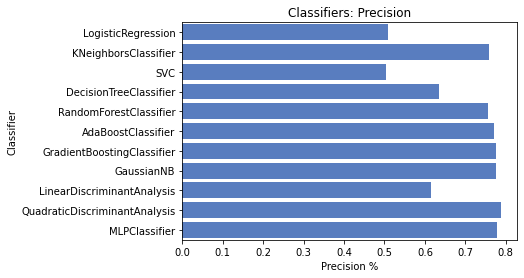

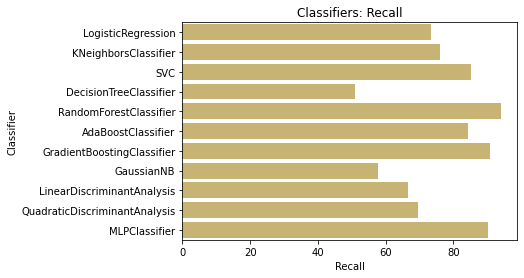

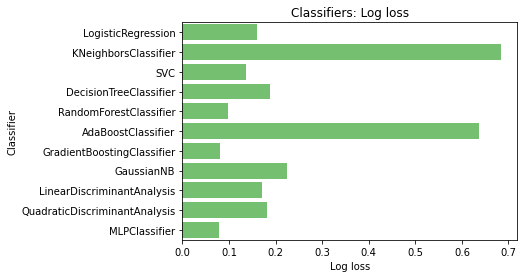

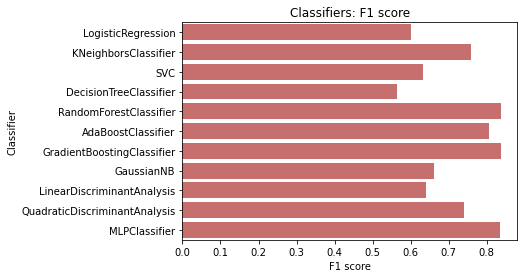

In [7]:
import seaborn as sns

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Classifiers: Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="y")
plt.xlabel('Recall')
plt.title('Classifiers: Recall')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")
plt.xlabel('Log loss')
plt.title('Classifiers: Log loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F1 score', y='Classifier', data=log, color="r")
plt.xlabel('F1 score')
plt.title('Classifiers: F1 score')
plt.show()

From these metrics we can see that the algorithms with the lowest logarithmic loss and the highest f1 score are:
- Random Forest
- Gradient Boosting
- MLP

In [8]:
# https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
import matplotlib

#MLP Classifier
mlp_clf = MLPClassifier(max_iter=400)
mlp_clf.fit(X_train, y_train)
mlp_prediction_proba = mlp_clf.predict_proba(X_test)[:, 1]
mlp_name = mlp_clf.__class__.__name__


# Random Forest 
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_prediction_proba = rf_clf.predict_proba(X_test)[:, 1]
rf_name = rf_clf.__class__.__name__

# Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_prediction_proba = gb_clf.predict_proba(X_test)[:, 1]
gb_name = gb_clf.__class__.__name__

## ROC curve and AUC
It is a classifier performance metric for various threshold settings that is mostly used in binary classifiers. The receiver operating characteristic (ROC) is the probability curve and the area under the curve (AUC) represents the degree or measure of separability. It tells us how much the model is able to distinguish between classes.

The decision to convert a predicted probability or score to a class label is governed by a parameter called "decision threshold", "discrimination threshold", or simply "threshold". The default value for the threshold is 0.5 for normalized probabilities or scores in the range of 0 to 1. 

For example, in a binary classification problem with labels of class 0 and 1, normalized predicted probabilities, and a threshold of 0.5, values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1: 

$$Prediction < 0.5  \implies \text{Class 0}$$

$$Prediction> = 0.5 \implies \text{Class 1}$$

The problem is that the predetermined threshold may not represent an optimal interpretation of the predicted probabilities.

The **ROC curve** is obtained by varying this threshold and plotting *recall vs. 1-specificity*, or the *true positives rate vs. false positive rate*.

The **AUC** is the area under the curve. The larger it is, the better the model distinguishing classes.

To make the ROC curve and calculate the AUC, we define the classifiers, train them, and make the predictions:

Plotting the curve for each classifier

In [9]:
from benchtools.src.metrictools import roc_plot, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

In [10]:
# Listing the name and probabilities to make the plots
names=[rf_name, mlp_name, gb_name]
probs=[rf_prediction_proba, mlp_prediction_proba, gb_prediction_proba]

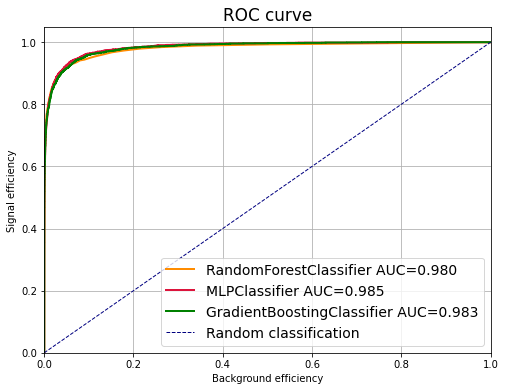

In [11]:
roc_plot(names=names, labels=y_test, probs=probs)
plt.show()

## Signal efficiency vs. Background rejection.
In HEP this graph is usually made. It is like the ROC curve except that what it's plotted is the *recall vs. specificity* or commonly known as *signal efficiency vs. background rejection*:

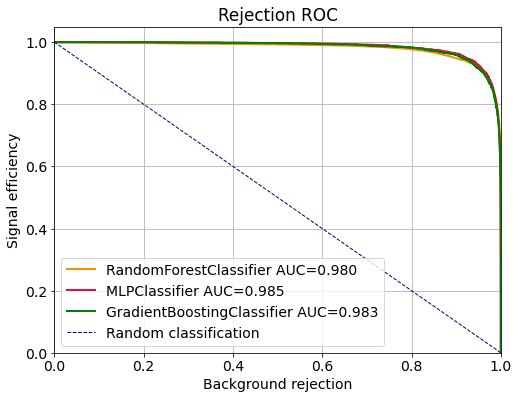

In [12]:
rejection_plot(names=names, labels=y_test, probs=probs)
plt.show()

## Inverse ROC

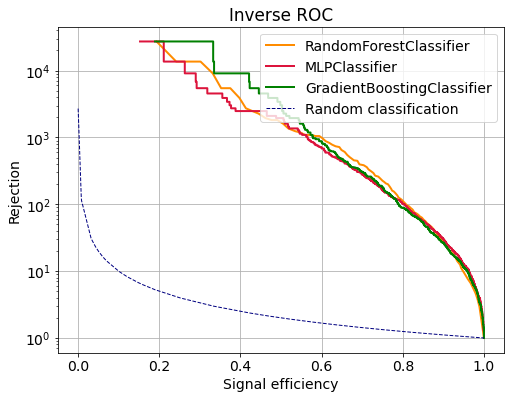

In [13]:
inverse_roc_plot(names=names, labels=y_test, probs=probs)
plt.show()

## Significance
The significance improvement is defined as the ratio of the signal efficiency to the square root of the background efficiency. A significance improvement of 2 means that the initial significance would be amplified by about a factor of two after employing the classification strategy

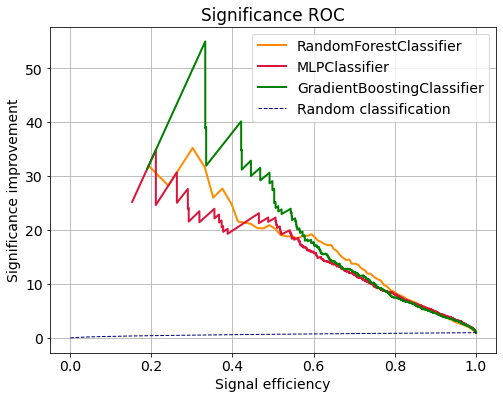

In [14]:
significance_plot(names=names, labels=y_test, probs=probs)
plt.show()

## Precision-recall curve
Above, there are plots relating the signal and background efficiency. However, they may not be the most suited when there is a large class imbalace: 
> However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

— [The Relationship Between Precision-Recall and ROC Curves, 2006](https://dl.acm.org/doi/10.1145/1143844.1143874)

> […] the visual interpretability of ROC plots in the context of imbalanced datasets can be deceptive with respect to conclusions about the reliability of classification performance, owing to an intuitive but wrong interpretation of specificity. [Precision-recall curve] plots, on the other hand, can provide the viewer with an accurate prediction of future classification performance due to the fact that they evaluate the fraction of true positives among positive predictions

— [The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets, 2015.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/)

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.
> If the proportion of positive to negative instances changes in a test set, the ROC curves will not change. Metrics such as accuracy, precision, lift and F scores use values from both columns of the confusion matrix. As a class distribution changes these measures will change as well, even if the fundamental classifier performance does not. ROC graphs are based upon TP rate and FP rate, in which each dimension is a strict columnar ratio, so do not depend on class distributions.

— [ROC Graphs: Notes and Practical Considerations for Data Mining Researchers, 2003.](http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf)

For more information on this, visit [this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
Here, I'll plot the precision-recall curve for each classifier and calculate the average precision (AP)

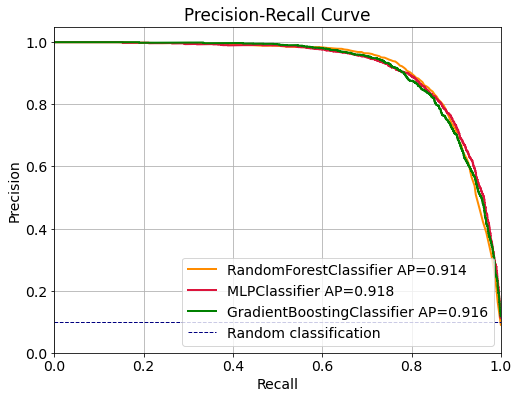

In [15]:
precision_recall_plot(names=names, labels=y_test, probs=probs)
plt.show()

## Feature importance
For each algorithm we can obtain the weight of each characteristic in the decision: 

In [16]:
fi_rf = rf_clf.feature_importances_.tolist()
fi_gb = gb_clf.feature_importances_.tolist()

weights = [fi_rf, fi_gb]
weights = [[ round(elem, 3) for elem in weight ] for weight in weights]
names_fi = [rf_name, gb_name]
features = X_train.columns.tolist()

importance = {}
ii = 0
for weight in weights:
    f_i = list(zip(features, weight))
    importance[names_fi[ii]] = f_i
    ii +=1

In [17]:
for name in names_fi:
    print(name)
    print('-'*120)
    print(importance[name])
    print('-'*120)

RandomForestClassifier
------------------------------------------------------------------------------------------------------------------------
[('pT_j1', 0.054), ('m_j1', 0.148), ('eta_j1', 0.016), ('phi_j1', 0.018), ('E_j1', 0.02), ('tau_21_j1', 0.094), ('nhadrons_j1', 0.037), ('pT_j2', 0.066), ('m_j2', 0.136), ('eta_j2', 0.016), ('phi_j2', 0.017), ('E_j2', 0.02), ('tau_21_j2', 0.083), ('nhadrons_j2', 0.04), ('m_jj', 0.119), ('deltaR_j12', 0.035), ('n_hadrons', 0.082)]
------------------------------------------------------------------------------------------------------------------------
GradientBoostingClassifier
------------------------------------------------------------------------------------------------------------------------
[('pT_j1', 0.026), ('m_j1', 0.196), ('eta_j1', 0.0), ('phi_j1', 0.0), ('E_j1', 0.0), ('tau_21_j1', 0.083), ('nhadrons_j1', 0.002), ('pT_j2', 0.096), ('m_j2', 0.153), ('eta_j2', 0.0), ('phi_j2', 0.0), ('E_j2', 0.0), ('tau_21_j2', 0.089), ('nhadrons_j2', 0.

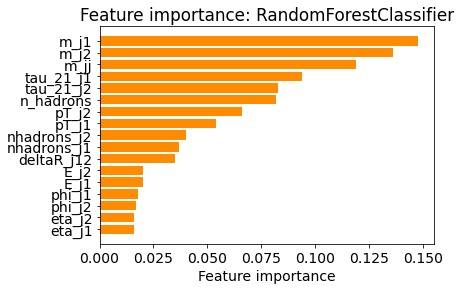

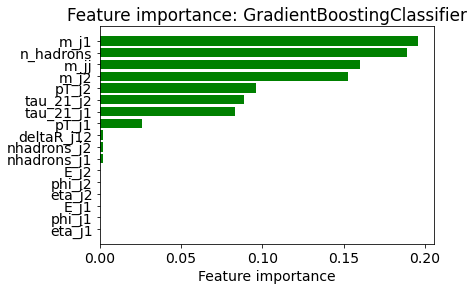

In [18]:
colors=['darkorange', 'green', 'crimson']
ii = 0
for name, scores in importance.items():

    # Sorting from smaller to largest
    scores.sort(key=lambda x: x[1], reverse=False) 

    # We save the names and their scores separately
    # and we reverse the tuples to have from highest to lowest score  
    features = list(zip(*scores))[0]
    score = list(zip(*scores))[1]
    x_pos = np.arange(len(features)) 

    # Plotting
    plt.barh(x_pos, score,align='center', color = colors[ii])
    plt.yticks(x_pos, features) 
    plt.xlabel('Feature importance')
    plt.title('Feature importance: {}'.format(name))
    plt.show()
    ii += 1

In both cases the invariant mass and the mass of the main and secondary jet are characteristics that the algorithm considers important.

Multilayer Perceptron does not have a method to obtain the importance of the characteristics.

## Model-free classification
So far we have done the classification with the invariant mass data. However, it is of interest to achieve a model-free classification, so we will run the same code again but without the mass.

In [19]:
# We separate the data into training and test sets
X, y = separate_data(df_RD)
X = X.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons
264511,0.178531,0.553014,0.122169,0.115549,0.295169,0.460630,0.398075,0.778744,0.613116,0.467802,0.304307,0.233871,0.468405,0.383430
446040,0.204718,0.265331,0.488231,0.333087,0.137716,0.074803,0.371607,0.402162,0.006291,0.251862,0.751581,0.153226,0.420884,0.115607
367350,0.003777,0.842060,0.978909,0.360864,0.551176,0.074803,0.275244,0.767909,0.491861,0.324097,0.425546,0.129032,0.423143,0.109827
510497,0.053667,0.726570,0.967108,0.183860,0.593012,0.047244,0.280254,0.628702,0.468625,0.192110,0.780424,0.213710,0.450905,0.179191
301480,0.012234,0.287852,0.956821,0.137224,0.729832,0.149606,0.286916,0.529381,0.458351,0.166240,0.704339,0.165323,0.490087,0.154143


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [21]:
# Record for visual comparison 
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    
    # Training the classifiers
    clf.fit(X_train, y_train)
    # Getting its names
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    # Obtaining predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    
    # Calculating metrics
    precision = precision_score(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Print the report
    print(classification_report(y_test, y_pred, target_names=['background','signal']))
    
    # Inserting the data in the dataframe
    log_entry = pd.DataFrame([[name, recall, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)

"""
    # Plotting the confusion matrix
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Normalized confusion matrix: {}".format(name))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Not normalized confusion matrix: {}".format(name))

    plt.show()
"""

print("="*30)

LogisticRegression
****Results****
              precision    recall  f1-score   support

  background       0.95      0.98      0.96     27297
      signal       0.71      0.43      0.53      2703

    accuracy                           0.93     30000
   macro avg       0.83      0.71      0.75     30000
weighted avg       0.92      0.93      0.93     30000

KNeighborsClassifier
****Results****
              precision    recall  f1-score   support

  background       0.96      0.97      0.97     27297
      signal       0.68      0.64      0.66      2703

    accuracy                           0.94     30000
   macro avg       0.82      0.80      0.81     30000
weighted avg       0.94      0.94      0.94     30000

SVC
****Results****
              precision    recall  f1-score   support

  background       0.94      0.99      0.97     27297
      signal       0.83      0.37      0.51      2703

    accuracy                           0.94     30000
   macro avg       0.89      0.68   

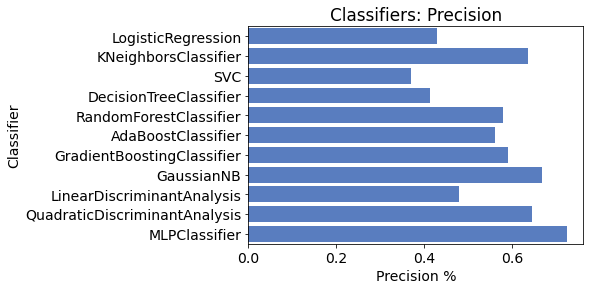

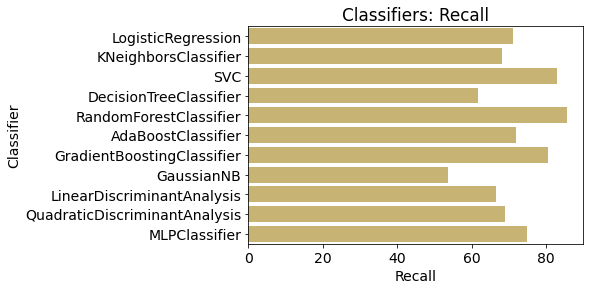

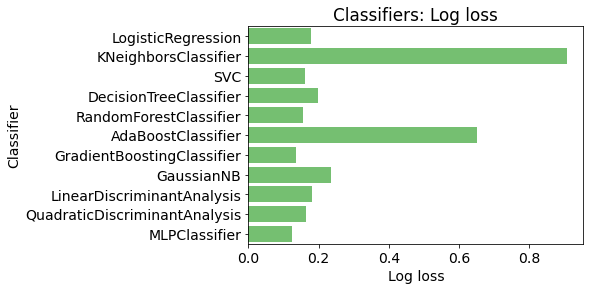

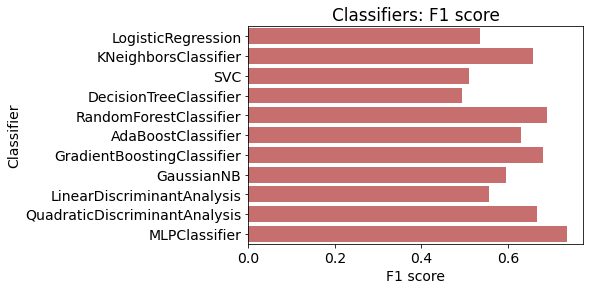

In [22]:
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Classifiers: Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="y")
plt.xlabel('Recall')
plt.title('Classifiers: Recall')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")
plt.xlabel('Log loss')
plt.title('Classifiers: Log loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F1 score', y='Classifier', data=log, color="r")
plt.xlabel('F1 score')
plt.title('Classifiers: F1 score')
plt.show()

In [23]:
#MLP Classifier
mlp_clf = MLPClassifier(max_iter=400)
mlp_clf.fit(X_train, y_train)
mlp_prediction_proba = mlp_clf.predict_proba(X_test)[:, 1]
mlp_name = mlp_clf.__class__.__name__

# Random Forest 
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_prediction_proba = rf_clf.predict_proba(X_test)[:, 1]
rf_name = rf_clf.__class__.__name__

# Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_prediction_proba = gb_clf.predict_proba(X_test)[:, 1]
gb_name = gb_clf.__class__.__name__

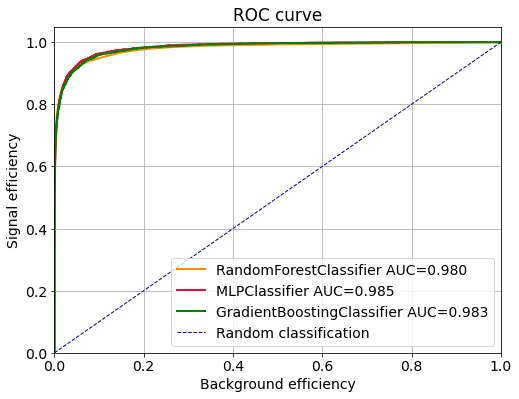

In [24]:
roc_plot(names=names, labels=y_test, probs=probs)
plt.show()

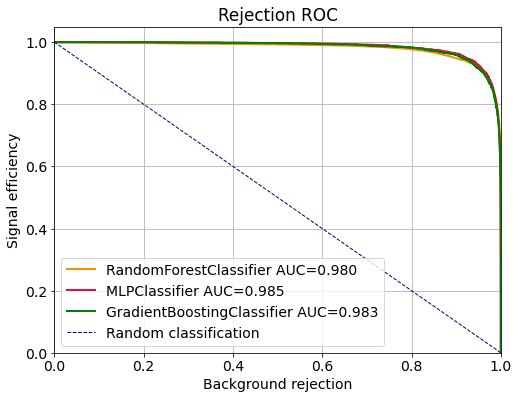

In [25]:
rejection_plot(names=names, labels=y_test, probs=probs)
plt.show()

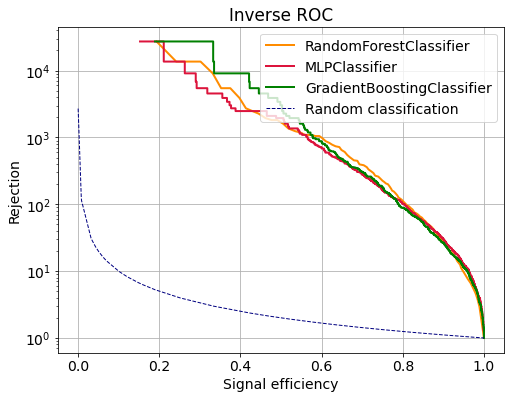

In [26]:
inverse_roc_plot(names=names, labels=y_test, probs=probs)
plt.show()

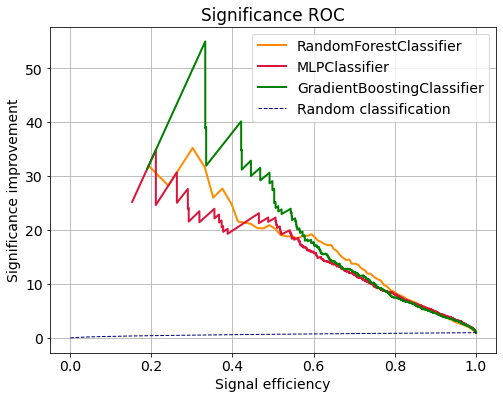

In [27]:
significance_plot(names=names, labels=y_test, probs=probs)
plt.show()

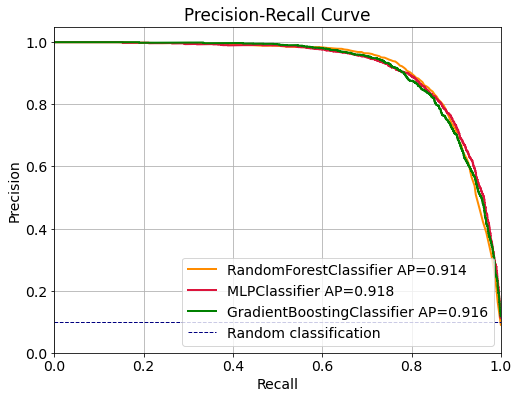

In [28]:
precision_recall_plot(names=names, labels=y_test, probs=probs)
plt.show()

In [29]:
fi_rf = rf_clf.feature_importances_.tolist()
fi_gb = gb_clf.feature_importances_.tolist()

weights = [fi_rf, fi_gb]
weights = [[ round(elem, 3) for elem in weight ] for weight in weights]
names_fi = [rf_name, gb_name]
features = X_train.columns.tolist()

importance = {}
ii = 0
for weight in weights:
    f_i = list(zip(features, weight))
    importance[names_fi[ii]] = f_i
    ii +=1

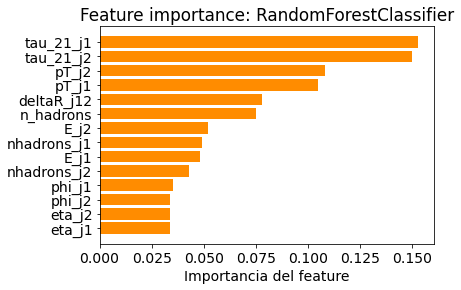

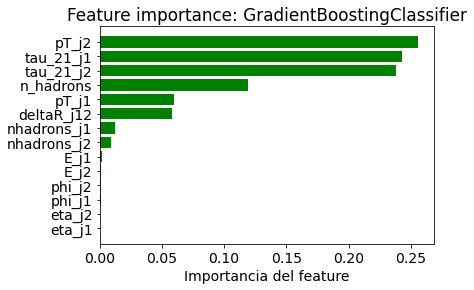

In [30]:
ii = 0
for name, scores in importance.items():

    # Ordenamos de menor a mayor
    scores.sort(key=lambda x: x[1], reverse=False) 

    # Salvamos los nombres y su puntaje separados
    # y revertimos las tuplas para tener de mayor a menor puntaje  
    features = list(zip(*scores))[0]
    score = list(zip(*scores))[1]
    x_pos = np.arange(len(features)) 

    # Graficamos
    plt.barh(x_pos, score,align='center', color = colors[ii])
    plt.yticks(x_pos, features) 
    plt.xlabel('Importancia del feature')
    plt.title('Feature importance: {}'.format(name))
    plt.show()
    ii += 1

By eliminating the masses, we see that the model relies more on the pT of the jets, the number of hadrons, and the substructure variable tau to classify the events.

## En BB1
Podemos probar estos clasificadores en la BB1:

In [31]:
# Generating the data. This cell just need to be run one time
build_features(path_data='..\..\events_LHCO2020_BlackBox1.h5', path_label= '..\..\events_LHCO2020_BlackBox1.masterkey', 
               nbatch=10, outname='BB1_dataset')

A file with that name already exists


In [32]:
# Loading the data
df_bb = pd.read_csv("..\data\BB1_dataset.csv")
df_bb.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0


In [33]:
# Preparing the data
df_bb = df_bb.sample(100000, random_state=6)
X_test, y_test = separate_data(df_bb)

X_test = X_test.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

In [34]:
# Listing the classifiers to compare
classifiers = [RandomForestClassifier(),
                MLPClassifier(max_iter=400),
                GradientBoostingClassifier(),]

# Record for visual comparison 
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    
    # Training the classifiers
    clf.fit(X_train, y_train)
    
    # Getting its names
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    # Obtaining predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    
    # Calculating metrics
    precision = precision_score(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Prin the report
    print(classification_report(y_test, y_pred, target_names=['background','signal']))
    
    # Inserting the data in the dataframe
    log_entry = pd.DataFrame([[name, recall, precision*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)

"""
    # Plotting the confusion matrix
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    
    disp.ax_.set_title("Normalized confusion matrix: {}".format(name))

    plt.show()
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['background','signal'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    
    disp.ax_.set_title("Not normalized confusion matrix: {}".format(name))

    plt.show()
"""

print("="*30)

RandomForestClassifier
****Results****
              precision    recall  f1-score   support

  background       1.00      0.99      1.00     99919
      signal       0.05      0.33      0.09        81

    accuracy                           0.99    100000
   macro avg       0.52      0.66      0.54    100000
weighted avg       1.00      0.99      1.00    100000

MLPClassifier
****Results****
              precision    recall  f1-score   support

  background       1.00      0.97      0.99     99919
      signal       0.02      0.59      0.03        81

    accuracy                           0.97    100000
   macro avg       0.51      0.78      0.51    100000
weighted avg       1.00      0.97      0.99    100000

GradientBoostingClassifier
****Results****
              precision    recall  f1-score   support

  background       1.00      0.99      1.00     99919
      signal       0.04      0.40      0.07        81

    accuracy                           0.99    100000
   macro avg    

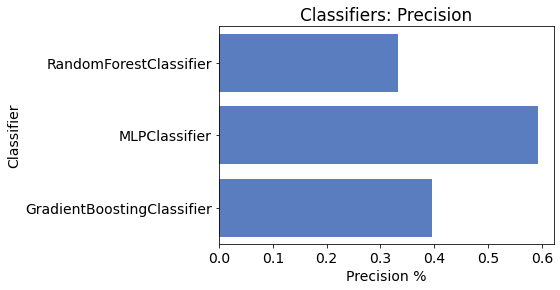

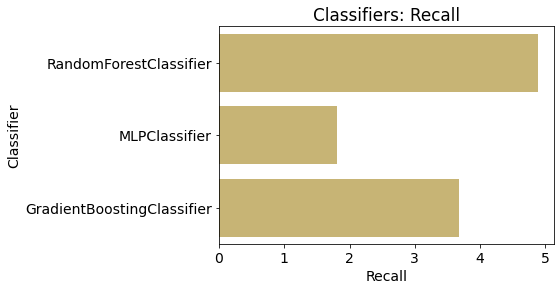

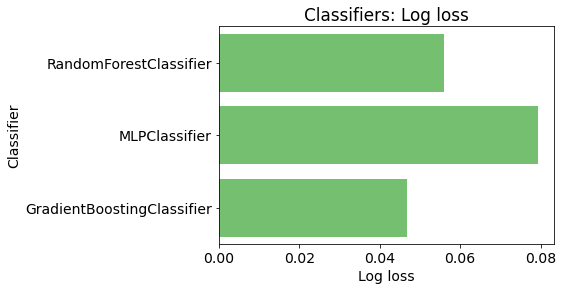

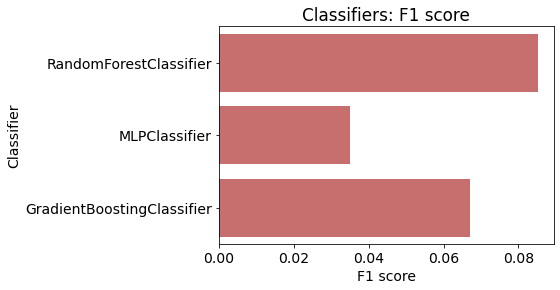

In [35]:
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="b")
plt.xlabel('Precision %')
plt.title('Classifiers: Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="y")
plt.xlabel('Recall')
plt.title('Classifiers: Recall')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")
plt.xlabel('Log loss')
plt.title('Classifiers: Log loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F1 score', y='Classifier', data=log, color="r")
plt.xlabel('F1 score')
plt.title('Classifiers: F1 score')
plt.show()

As expected by the little percentage of signal on this dataset, the classifiers aren't as precise classifying.